# Predicting Multipartite and Unipartite genome based on differentially present genes on respective genomes¶

Following is a machine learning framework that uses differentially present genes present in Multipartite and Unipartite Genomes to predict the phenotype and prioritize the most important genes that separate the respective phenotype

Jupyter Notebook by: Janak Sunuwar

In [1]:
# filename = input file
file_name = 'https://github.com/Janaksunuwar/Predicting-Multipartite-and-Unipartite-Bacterial-Genomes/raw/main/Data/Final_Multipartite_matrix_DEG_level.csv'

# Result out
file_all_out = "1.Final_Multipartite_DEG_Level_All_Out.csv"

# level of run
level = 'DEG_Level'

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
np.random.seed(1)
import sklearn
import sklearn.model_selection
import sklearn.metrics
import sklearn.ensemble
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline

 #Import classifiers
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut 
from sklearn.model_selection import cross_val_score

data = pd.read_csv(file_name)
row = len(data)
column = len(data.columns)
#select features besides the phenotype/label
X = data.iloc[:, 1:-2] 
# select the label/phenotype
Y = data.iloc[:,-1] # last column label

#create a dataframe for the final output of the program
Tf_CV = pd.DataFrame(columns=[])
Training_Performance = pd.DataFrame(columns=[])
Test_Performance = pd.DataFrame(columns=[])
Area_Under_ROC = pd.DataFrame(columns=[])
Area_Under_Precision_Recall = pd.DataFrame(columns=[])
#split the data in six equal parts
kf = KFold(n_splits=6)
i = 0
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    #Build model and evaluate models
    models = []
    models.append(('LogR', LogisticRegression()))
    models.append(('gNB', GaussianNB()))
    models.append(('SVM', SVC(kernel = 'rbf', probability=True)))
    models.append(('DT', DecisionTreeClassifier(criterion = 'entropy', random_state=1)))
    models.append(('RF', RandomForestClassifier(criterion = 'entropy', random_state=0)))
    models.append(('KNN', KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('mNB', MultinomialNB()))
    models.append(('ABC', AdaBoostClassifier()))
    models.append(('GBC', GradientBoostingClassifier()))
    models.append(('ETC', ExtraTreesClassifier()))
    models.append(('BC', BaggingClassifier()))
    
    myDF = pd.DataFrame(columns=[])
    #Evaluate each model
    for name, model in models:
        kfold = model_selection.KFold(n_splits=10)
        results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold)
        mean= results.mean().round(3)
        std = results.std()
        myDF = myDF.append({'classifier': name, f'ten_f_CV{i+1}':mean}, ignore_index = True)
    Tf_CV = pd.concat([Tf_CV, myDF], axis = 1)

    #TRAINING PERFORMANCE
    myDF1 = pd.DataFrame(columns=[])
    for name, model in models:    
        model = model.fit(X_train, Y_train)
        Y_train_pred = model.predict(X_train)
        Tr_precision = precision_score(Y_train, Y_train_pred, average='macro').round(3)
        Tr_recall = recall_score(Y_train, Y_train_pred, average='macro').round(3)
        Tr_f1 = f1_score (Y_train, Y_train_pred, average='macro').round(3)
        myDF1 = myDF1.append({'classifier': name, f'tr_precision{i+1}': Tr_precision, f'tr_recall{i+1}': Tr_recall, f'tr_f1 {i+1}':Tr_f1}, ignore_index = True)
    Training_Performance = pd.concat([Training_Performance, myDF1], axis = 1)
 
    #TEST PERFORMANCE
    myDF2 = pd.DataFrame(columns=[])
    for name, model in models:  
        model = model.fit(X_train, Y_train)
        Y_test_pred = model.predict(X_test)
        report = sklearn.metrics.classification_report(Y_test, Y_test_pred)
        Te_precision = precision_score(Y_test, Y_test_pred, average='macro').round(3)
        Te_recall = recall_score(Y_test, Y_test_pred, average='macro').round(3)
        Te_f1 = f1_score (Y_test, Y_test_pred, average='macro').round(3)
        myDF2 = myDF2.append({'classifier': name, f'te_precision{i+1}': Te_precision, f'te_recall{i+1}': Te_recall, f'te_f1 {i+1}':Te_f1}, ignore_index = True)
    Test_Performance = pd.concat([Test_Performance, myDF2], axis = 1)
    
    #AU_ROC
    myDF3 = pd.DataFrame(columns=[])
    for name, model in models:
        model = model.fit(X_train, Y_train)
        y_pred_proba = model.predict_proba(X_test)[::,1]
        # keep probabilities for the positive outcome only
        
        fpr, tpr, _ = roc_curve(Y_test,  y_pred_proba, pos_label = None)
        a_u_c = roc_auc_score(Y_test, y_pred_proba).round(3)
        myDF3 = myDF3.append({'a classifier': name, f'au ROC {i+1}': a_u_c}, ignore_index = True)
    Area_Under_ROC = pd.concat([Area_Under_ROC, myDF3], axis = 1)
    
    #AU precision recall
    myDF4 = pd.DataFrame(columns=[])
    for name, model in models:
        #predict probabilities
        y_pred_proba = model.predict_proba(X_test)
        # keep probabilities for the positive outcome only
        y_pred_proba = y_pred_proba[:, 1]
        #predict class vlaues
        y_pred = model.predict(X_test)
        # calculate precision-recall curve
        precision, recall, _ = precision_recall_curve(Y_test, y_pred_proba)
        # calculate au precision-recall curve
        area = auc(recall, precision).round(3)
        # calculate f1 score
        f1 = f1_score(Y_test, y_pred, average='weighted').round(3)
        myDF4 = myDF4.append({'a classifier': name, f'au PR {i+1}': area}, ignore_index = True)
    Area_Under_Precision_Recall = pd.concat([Area_Under_Precision_Recall, myDF4], axis = 1)
    i += 1
    
#Model names
Models = Tf_CV.iloc[:, 0] 

#Calculating the mean of all folds
#training f1 average
tr_f1_avg = Training_Performance[Training_Performance.columns[1::4]].mean(axis=1).round(3).rename('tr_f1_avg_as', inplace=True)
tr_f1_stdev = Training_Performance[Training_Performance.columns[1::4]].std(axis=1).round(3).rename('tr_f1_stdev_as', inplace=True)

#Training precision average
tr_precision_avg = Training_Performance[Training_Performance.columns[2::4]].mean(axis=1).round(3).rename('tr_precision_avg_as', inplace=True)
tr_precision_stdev = Training_Performance[Training_Performance.columns[2::4]].std(axis=1).round(3).rename('tr_precision_stdev_as', inplace=True)

#Training recall average
tr_recall_avg = Training_Performance[Training_Performance.columns[3::4]].mean(axis=1).round(3).rename('tr_recall_avg_as', inplace=True)
tr_recall_stdev = Training_Performance[Training_Performance.columns[3::4]].std(axis=1).round(3).rename('tr_recall_stdev_as', inplace=True)

#Test f1 average
te_f1_avg = Test_Performance[Test_Performance.columns[1::4]].mean(axis=1).round(3).rename('te_f1_avg_as', inplace=True)
te_f1_stdev = Test_Performance[Test_Performance.columns[1::4]].std(axis=1).round(3).rename('te_f1_stdev_as', inplace=True)

#Test precision average
te_precision_avg = Test_Performance[Test_Performance.columns[2::4]].mean(axis=1).round(3).rename('te_precision_avg_as', inplace=True)
te_precision_stdev = Test_Performance[Test_Performance.columns[2::4]].std(axis=1).round(3).rename('te_precision_stdev_as', inplace=True)

#Test recall average
te_recall_avg = Test_Performance[Test_Performance.columns[3::4]].mean(axis=1).round(3).rename('te_recall_avg_as', inplace=True)
te_recall_stdev = Test_Performance[Test_Performance.columns[3::4]].std(axis=1).round(3).rename('te_recall_stdev_as', inplace=True)

#Tf_CV average
Tf_CV_Avg = Tf_CV[Tf_CV.columns[1::2]].mean(axis=1).round(3).rename('Tf_CV_Avg_as', inplace=True)
Tf_CV_stdev = Tf_CV[Tf_CV.columns[1::2]].std(axis=1).round(3).rename('Tf_CV_stdev_as', inplace=True)

#Area_Under_ROC average
au_ROC_avg = Area_Under_ROC[Area_Under_ROC.columns[1::2]].mean(axis=1).round(3).rename('au_ROC_avg_as', inplace=True)
au_ROC_stdev = Area_Under_ROC[Area_Under_ROC.columns[1::2]].std(axis=1).round(3).rename('au_ROC_stdev_as', inplace=True)

#Area_Under_Precision_Recall average
au_PR_avg= Area_Under_Precision_Recall[Area_Under_Precision_Recall.columns[1::2]].mean(axis=1).round(3).rename('au_PR_avg_as', inplace=True)
au_PR_stdev= Area_Under_Precision_Recall[Area_Under_Precision_Recall.columns[1::2]].std(axis=1).round(3).rename('au_PR_stdev_as', inplace=True)

#Accumulating all dataframes
frames2 = [Models, 
           tr_precision_avg, tr_precision_stdev, tr_recall_avg, tr_recall_stdev, tr_f1_avg, tr_f1_stdev, 
           te_precision_avg, te_precision_stdev, te_recall_avg, te_recall_stdev, te_f1_avg, te_f1_stdev,
           Tf_CV_Avg, Tf_CV_stdev, au_ROC_avg, au_ROC_stdev, au_PR_avg, au_PR_stdev]

#Result all set
Final_All_set_Results= pd.concat(frames2, axis=1)

with open (file_all_out, 'a+') as Result_file:
    Result_file.write(f'\nResults_All_Set_Multipartite_{level}\n')
    Result_file.write(f"The matrix size {row} X {column}")
    Final_All_set_Results.to_csv(Result_file)
    
#Export results separately
Final_All_set_Results.to_csv(f'Multipartite_{level}_All_Set_Performance.csv', encoding='utf-8')
   
print('All Set Performance')
display (Final_All_set_Results)
    
#FEATURE IMPORTANCE to get consistent genes=Target genes in 6 Folds
import pandas as pd
#We can use the folds from K-Fold as an iterator 
#and use it in a for loop to perform the training on a pandas dataframe
#Defin the KFold class and train the model
from sklearn.model_selection import KFold
kf = KFold(n_splits = 6)
clfk = LogisticRegression(random_state=1)
model_names = 'LR'
myDF5 = pd.DataFrame(columns=[])
scores = []
test_scores = []
check_feat = []

Output = pd.DataFrame()
kf = KFold(n_splits=6)
j = 0
for train_index, test_index in kf.split(X):
    myDF51= pd.DataFrame(columns=[])
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]    
    modelk = clfk.fit(X_train,Y_train)
    predictions = clfk.predict(X_test)
    scores.append(clfk.score(X_test, Y_test))
    # feature importance logistic regression
    feat = list(clfk.coef_.T)
    # select the column header from first to the second last
    colhead = list(np.array([data.columns[1:-1]]).T)
    # zip tow columns into a dataframe
    list_of_tuplesk= list(zip(colhead, feat))
    # create a dataframe
    feature_importancek = pd.DataFrame(list_of_tuplesk, columns = [f'Feature fold{j}', f'Importance fold{j}'])
    # sort the dataframe, descending
    feature_importance_sortedk = feature_importancek.sort_values(by=f'Importance fold{j}', ascending=False)
    # remove the square brackets from the dataframe
    feature_importance_sortedk [f'Feature fold{j}'] = feature_importance_sortedk[f'Feature fold{j}'].str.get(0)
    feature_importance_sortedk = feature_importance_sortedk.round(3)
    test_df = pd.DataFrame(feature_importance_sortedk)
    test_df.reset_index(drop=True, inplace=True)
    myDF5.reset_index(drop=True, inplace=True)
    myDF5 = pd.concat([myDF5, test_df], axis= 1)
    j += 1

# select the number of top genes in the list
top_genes_no = 200
# make dataframe of selected top dataframes
Top_consistent = myDF5.iloc[0:top_genes_no, :]
# separate each column to separate dataframe and find common in all
cdf1 = Top_consistent[['Feature fold0']].rename(columns={"Feature fold0": "Feature"})
cdf2 = Top_consistent[['Feature fold1']].rename(columns={"Feature fold1": "Feature"})
cdf3 = Top_consistent[['Feature fold2']].rename(columns={"Feature fold2": "Feature"})
cdf4 = Top_consistent[['Feature fold3']].rename(columns={"Feature fold3": "Feature"})
cdf5 = Top_consistent[['Feature fold4']].rename(columns={"Feature fold4": "Feature"})
cdf6 = Top_consistent[['Feature fold5']].rename(columns={"Feature fold5": "Feature"})
merge12 = pd.merge(cdf1, cdf2, how='inner', on=['Feature'])
merge123 = pd.merge(merge12, cdf3, how='inner', on=['Feature'])
merge1234 = pd.merge(merge123, cdf4, how='inner', on=['Feature'])
merge12345 = pd.merge(merge1234, cdf5, how='inner', on=['Feature'])
Final_Consistent_Genes_Multipartite = pd.merge(merge12345, cdf6, how='inner', on=['Feature'])

#Export to all file out result file
with open (file_all_out, 'a+') as Result_file:
    Result_file.write(f'\nNo. of Top genes {top_genes_no} {level}\n')
    Result_file.write(f'\nFinal_Consistent_Genes_Multipartite_{level}\n')
    Final_Consistent_Genes_Multipartite.to_csv(Result_file)
    
# export separate consistent genes names
Final_Consistent_Genes_Multipartite.to_csv(f'2.Final_Consistent_Genes_Multipartite_{level}.csv', encoding='utf-8')

#########################################
#INTERSECTION RUN

data = pd.read_csv(file_name)

#read gene_ast matrix
open_gene_ast = pd.read_csv(file_name)
# read file to dataframe
open_consistent_genes = pd.read_csv(f'2.Final_Consistent_Genes_Multipartite_{level}.csv')

# make separate dataframe with just consistent genes
target_genesTT = open_consistent_genes[['Feature']].rename(columns={'Feature': 'Consistent genes'})

#No of top consistent genes
num = 15
target_genesTT = target_genesTT.iloc[:num, :]

# sort the consistent genes 
target_genesTT = target_genesTT.sort_values('Consistent genes')
# adding antibiotic lable at the end
target_genes_good = target_genesTT.append({'Consistent genes': 'Label'}, ignore_index=True)
# converting consistent genes to a list
column_list = target_genes_good['Consistent genes'].tolist()

#ALL DATA
#make gene, ast matrix consisting only of consistent genes 
data = open_gene_ast[column_list]
X= data.iloc[:, 1:-1]
Y = data.iloc[:,-1]

#create a dataframe for the final output of the program
Tf_CV = pd.DataFrame(columns=[])
Training_Performance = pd.DataFrame(columns=[])
Test_Performance = pd.DataFrame(columns=[])
Area_Under_ROC = pd.DataFrame(columns=[])
Area_Under_Precision_Recall = pd.DataFrame(columns=[])

kf = KFold(n_splits=6)
i = 0
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    #Build model and evaluate models
    models = []
    models.append(('LogR', LogisticRegression()))
    models.append(('gNB', GaussianNB()))
    models.append(('SVM', SVC(kernel = 'rbf', probability=True)))
    models.append(('DT', DecisionTreeClassifier(criterion = 'entropy', random_state=1)))
    models.append(('RF', RandomForestClassifier(criterion = 'entropy', random_state=0)))
    models.append(('KNN', KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('mNB', MultinomialNB()))
    models.append(('ABC', AdaBoostClassifier()))
    models.append(('GBC', GradientBoostingClassifier()))
    models.append(('ETC', ExtraTreesClassifier()))
    models.append(('BC', BaggingClassifier()))
    
    myDF = pd.DataFrame(columns=[])
    #Evaluate each model
    for name, model in models:
        kfold = model_selection.KFold(n_splits=10)
        results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold)
        mean= results.mean().round(3)
        std = results.std()
        myDF = myDF.append({'classifier': name, f'ten_f_CV{i+1}':mean}, ignore_index = True)
    Tf_CV = pd.concat([Tf_CV, myDF], axis = 1)

    #TRAINING PERFORMANCE
    myDF1 = pd.DataFrame(columns=[])
    for name, model in models:    
        model = model.fit(X_train, Y_train)
        Y_train_pred = model.predict(X_train)
        Tr_precision = precision_score(Y_train, Y_train_pred, average='macro').round(3)
        Tr_recall = recall_score(Y_train, Y_train_pred, average='macro').round(3)
        Tr_f1 = f1_score (Y_train, Y_train_pred, average='macro').round(3)
        myDF1 = myDF1.append({'classifier': name, f'tr_precision{i+1}': Tr_precision, f'tr_recall{i+1}': Tr_recall, f'tr_f1 {i+1}':Tr_f1}, ignore_index = True)
    Training_Performance = pd.concat([Training_Performance, myDF1], axis = 1)
 
    #TEST PERFORMANCE
    myDF2 = pd.DataFrame(columns=[])
    for name, model in models:  
        model = model.fit(X_train, Y_train)
        Y_test_pred = model.predict(X_test)
        report = sklearn.metrics.classification_report(Y_test, Y_test_pred)
        Te_precision = precision_score(Y_test, Y_test_pred, average='macro').round(3)
        Te_recall = recall_score(Y_test, Y_test_pred, average='macro').round(3)
        Te_f1 = f1_score (Y_test, Y_test_pred, average='macro').round(3)
        myDF2 = myDF2.append({'classifier': name, f'te_precision{i+1}': Te_precision, f'te_recall{i+1}': Te_recall, f'te_f1 {i+1}':Te_f1}, ignore_index = True)
    Test_Performance = pd.concat([Test_Performance, myDF2], axis = 1)
    
    #AU_ROC
    myDF3 = pd.DataFrame(columns=[])
    for name, model in models:
        model = model.fit(X_train, Y_train)
        y_pred_proba = model.predict_proba(X_test)[::,1]
        # keep probabilities for the positive outcome only
        
        fpr, tpr, _ = roc_curve(Y_test,  y_pred_proba, pos_label = None)
        a_u_c = roc_auc_score(Y_test, y_pred_proba).round(3)
        myDF3 = myDF3.append({'a classifier': name, f'au ROC {i+1}': a_u_c}, ignore_index = True)
    Area_Under_ROC = pd.concat([Area_Under_ROC, myDF3], axis = 1)
    
    #Area under precision recall
    myDF4 = pd.DataFrame(columns=[])
    for name, model in models:
        #predict probabilities
        y_pred_proba = model.predict_proba(X_test)
        # keep probabilities for the positive outcome only
        y_pred_proba = y_pred_proba[:, 1]
        #predict class vlaues
        y_pred = model.predict(X_test)
        # calculate precision-recall curve
        precision, recall, _ = precision_recall_curve(Y_test, y_pred_proba)
        # calculate au precision-recall curve
        area = auc(recall, precision).round(3)
        # calculate f1 score
        f1 = f1_score(Y_test, y_pred, average='weighted').round(3)
        myDF4 = myDF4.append({'a classifier': name, f'au PR {i+1}': area}, ignore_index = True)
    Area_Under_Precision_Recall = pd.concat([Area_Under_Precision_Recall, myDF4], axis = 1)
    i += 1
    
#Model names
Models = Tf_CV.iloc[:, 0] 

#training f1 average
tr_f1_avg = Training_Performance[Training_Performance.columns[1::4]].mean(axis=1).round(3).rename('tr_f1_avg_is', inplace=True)
tr_f1_stdev = Training_Performance[Training_Performance.columns[1::4]].std(axis=1).round(3).rename('tr_f1_stdev_is', inplace=True)

#Training precision average
tr_precision_avg = Training_Performance[Training_Performance.columns[2::4]].mean(axis=1).round(3).rename('tr_precision_avg_is', inplace=True)
tr_precision_stdev = Training_Performance[Training_Performance.columns[2::4]].std(axis=1).round(3).rename('tr_precision_stdev_is', inplace=True)

#Training recall average
tr_recall_avg = Training_Performance[Training_Performance.columns[3::4]].mean(axis=1).round(3).rename('tr_recall_avg_is', inplace=True)
tr_recall_stdev = Training_Performance[Training_Performance.columns[3::4]].std(axis=1).round(3).rename('tr_recall_stdev_is', inplace=True)

#Test f1 average
te_f1_avg = Test_Performance[Test_Performance.columns[1::4]].mean(axis=1).round(3).rename('te_f1_avg_is', inplace=True)
te_f1_stdev = Test_Performance[Test_Performance.columns[1::4]].std(axis=1).round(3).rename('te_f1_stdev_is', inplace=True)

#Test precision average
te_precision_avg = Test_Performance[Test_Performance.columns[2::4]].mean(axis=1).round(3).rename('te_precision_avg_is', inplace=True)
te_precision_stdev = Test_Performance[Test_Performance.columns[2::4]].std(axis=1).round(3).rename('te_precision_stdev_is', inplace=True)

#Test recall average
te_recall_avg = Test_Performance[Test_Performance.columns[3::4]].mean(axis=1).round(3).rename('te_recall_avg_is', inplace=True)
te_recall_stdev = Test_Performance[Test_Performance.columns[3::4]].std(axis=1).round(3).rename('te_recall_stdev_is', inplace=True)

#Tf_CV average
Tf_CV_Avg = Tf_CV[Tf_CV.columns[1::2]].mean(axis=1).round(3).rename('Tf_CV_Avg_is', inplace=True)
Tf_CV_stdev = Tf_CV[Tf_CV.columns[1::2]].std(axis=1).round(3).rename('Tf_CV_stdev_is', inplace=True)

#Area_Under_ROC average
au_ROC_avg = Area_Under_ROC[Area_Under_ROC.columns[1::2]].mean(axis=1).round(3).rename('au_ROC_avg_is', inplace=True)
au_ROC_stdev = Area_Under_ROC[Area_Under_ROC.columns[1::2]].std(axis=1).round(3).rename('au_ROC_stdev_is', inplace=True)

#Area_Under_Precision_Recall average
au_PR_avg= Area_Under_Precision_Recall[Area_Under_Precision_Recall.columns[1::2]].mean(axis=1).round(3).rename('au_PR_avg_is', inplace=True)
au_PR_stdev= Area_Under_Precision_Recall[Area_Under_Precision_Recall.columns[1::2]].std(axis=1).round(3).rename('au_PR_stdev_is', inplace=True)

#Accumulating all dataframes
frames2 = [Models, 
           tr_precision_avg, tr_precision_stdev, tr_recall_avg, tr_recall_stdev, tr_f1_avg, tr_f1_stdev, 
           te_precision_avg, te_precision_stdev, te_recall_avg, te_recall_stdev, te_f1_avg, te_f1_stdev,
           Tf_CV_Avg, Tf_CV_stdev, au_ROC_avg, au_ROC_stdev, au_PR_avg, au_PR_stdev]

#Result all set
Final_Intersection_set_Results= pd.concat(frames2, axis=1)

with open (file_all_out, 'a+') as Result_file:
    Result_file.write(f'\nIntersection Multipartite {level}\n')
    Result_file.write(f'\nNo. of top consistent gene {num}')
    Final_Intersection_set_Results.to_csv(Result_file)

# export separate Intersection results
Final_Intersection_set_Results.to_csv(f'3.Multipartite_{level}_Intersection_Set_Performance.csv', encoding='utf-8')

print('Intersection Set Performance')
display(Final_Intersection_set_Results)

###############################################
#Random Set Run
num = 15

daa = pd.read_csv(file_name)

label = daa[['Label']]

daa = daa.drop(['Accessions', 'Label'], axis=1)

view_daa = daa.iloc[:, [0,1,2,3,-3, -2,-1]]

#Create a dataframe for the final output of the program
Random_Set_Results = pd.DataFrame(columns=[])

#Select 10 random sets
for k in range(10):
    samp = daa.sample(n=num, replace = False, axis=1)
    data = pd.concat([samp, label], axis=1)
    X = data.iloc[:, 1:num]
    Y = data.iloc[:,-1]
    #Dataframes for results
    Tf_CV = pd.DataFrame(columns=[])
    Training_Performance = pd.DataFrame(columns=[])
    Test_Performance = pd.DataFrame(columns=[])
    Area_Under_ROC = pd.DataFrame(columns=[])
    Area_Under_Precision_Recall = pd.DataFrame(columns=[])
    Model_Predict = pd.DataFrame(columns=[])
    kf = KFold(n_splits=10)
    ij = 0
    #Split the data
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

        #Build model and evaluate models
        models = []
        models.append(('LogR', LogisticRegression(max_iter=10000)))
        models.append(('gNB', GaussianNB()))
        models.append(('SVM', SVC(kernel = 'rbf', probability=True)))
        models.append(('DT', DecisionTreeClassifier(criterion = 'entropy', random_state=1)))
        models.append(('RF', RandomForestClassifier(criterion = 'entropy', random_state=0)))
        models.append(('KNN', KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)))
        models.append(('LDA', LinearDiscriminantAnalysis()))
        models.append(('mNB', MultinomialNB()))
        models.append(('ABC', AdaBoostClassifier()))
        models.append(('GBC', GradientBoostingClassifier()))
        models.append(('ETC', ExtraTreesClassifier()))
        models.append(('BC', BaggingClassifier()))

        #Training performance
        myDF1 = pd.DataFrame(columns=[])
        for name, model in models:    
            model = model.fit(X_train, Y_train)
            Y_train_pred = model.predict(X_train)
            Tr_precision = precision_score(Y_train, Y_train_pred).round(3)
            Tr_recall = recall_score(Y_train, Y_train_pred).round(3)
            Tr_f1 = f1_score (Y_train, Y_train_pred).round(3)
            myDF1 = myDF1.append({'classifier': name, f'tr_precision{ij+1}': Tr_precision, f'tr_recall{ij+1}': Tr_recall, f'tr_f1 {ij+1}':Tr_f1}, ignore_index = True)
        Training_Performance = pd.concat([Training_Performance, myDF1], axis = 1)

        #Test performance
        myDF2 = pd.DataFrame(columns=[])
        for name, model in models:  
            model = model.fit(X_train, Y_train)
            Y_test_pred = model.predict(X_test)
            report = sklearn.metrics.classification_report(Y_test, Y_test_pred)
            Te_precision = precision_score(Y_test, Y_test_pred).round(3)
            Te_recall = recall_score(Y_test, Y_test_pred).round(3)
            Te_f1 = f1_score (Y_test, Y_test_pred).round(3)
            myDF2 = myDF2.append({'classifier': name, f'te_precision{ij+1}': Te_precision, f'te_recall{ij+1}': Te_recall, f'te_f1 {ij+1}':Te_f1}, ignore_index = True)
        Test_Performance = pd.concat([Test_Performance, myDF2], axis = 1)

        #Ten-fold cross validation
        myDF = pd.DataFrame(columns=[])
        for name, model in models:
            kfold = model_selection.KFold(n_splits=10)
            results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold)
            mean= results.mean().round(3)
            std = results.std()
            myDF = myDF.append({'classifier': name, f'ten_f_CV{ij+1}':mean}, ignore_index = True)
        Tf_CV = pd.concat([Tf_CV, myDF], axis = 1)

        #AU_ROC
        myDF3 = pd.DataFrame(columns=[])
        for name, model in models:
            model = model.fit(X_train, Y_train)
            y_pred_proba = model.predict_proba(X_test)[::,1]
            # keep probabilities for the positive outcome only

            fpr, tpr, _ = roc_curve(Y_test,  y_pred_proba, pos_label = None)
            a_u_c = roc_auc_score(Y_test, y_pred_proba).round(3)
            myDF3 = myDF3.append({'classifier': name, f'au ROC {ij+1}': a_u_c}, ignore_index = True)
        Area_Under_ROC = pd.concat([Area_Under_ROC, myDF3], axis = 1)

        #AUPR
        myDF4 = pd.DataFrame(columns=[])
        for name, model in models:
            #predict probabilities
            y_pred_proba = model.predict_proba(X_test)
            # keep probabilities for the positive outcome only
            y_pred_proba = y_pred_proba[:, 1]
            #predict class vlaues
            y_pred = model.predict(X_test)
            # calculate precision-recall curve
            precision, recall, _ = precision_recall_curve(Y_test, y_pred_proba)
            # calculate au precision-recall curve
            area = auc(recall, precision).round(3)
            # calculate f1 score
            f1 = f1_score(Y_test, y_pred, average='weighted').round(3)
            myDF4 = myDF4.append({'classifier': name, f'au PR {ij+1}': area}, ignore_index = True)
        Area_Under_Precision_Recall = pd.concat([Area_Under_Precision_Recall, myDF4], axis = 1)
        ij += 1

    #List for output
    myDF5 = pd.DataFrame(columns=[])

    #Model names
    Models = Tf_CV.iloc[:, 0]

    #Training_Performance F1 average
    tr_f1_avg = Training_Performance[Training_Performance.columns[1::4]].mean(axis=1).round(3)
    tr_f1_avg = tr_f1_avg.rename(f'tr_f1_avg_{k}', inplace=True)

    #Training_Performance precision average
    tr_precision_avg = Training_Performance[Training_Performance.columns[2::4]].mean(axis=1).round(3)
    tr_precision_avg = tr_precision_avg.rename(f'tr_precision_avg_{k}', inplace=True)

    #Training_Performance recall average
    tr_recall_avg = Training_Performance[Training_Performance.columns[3::4]].mean(axis=1).round(3)
    tr_recall_avg = tr_recall_avg.rename(f'tr_recall_avg_{k}', inplace=True)

    #Test_Performance f1 average
    te_f1_avg = Test_Performance[Test_Performance.columns[1::4]].mean(axis=1).round(3)
    te_f1_avg = te_f1_avg.rename(f'te_f1_avg_{k}', inplace=True)

    #Test_Performance precision average
    te_precision_avg = Test_Performance[Test_Performance.columns[2::4]].mean(axis=1).round(3)
    te_precision_avg = te_precision_avg.rename(f'te_precision_avg_{k}', inplace=True)

    #Test_Performance recall average
    te_recall_avg = Test_Performance[Test_Performance.columns[3::4]].mean(axis=1).round(3)
    te_recall_avg = te_recall_avg.rename(f'te_recall_avg_{k}', inplace=True)

    #Ten fold crossvalidation average
    Tf_CV_Avg = Tf_CV[Tf_CV.columns[1::2]].mean(axis=1).round(3)
    Tf_CV_Avg = Tf_CV_Avg.rename(f'Tf_CV_Avg_{k}', inplace=True)

    #Area_Under_ROC average
    au_ROC_avg_rs = Area_Under_ROC[Area_Under_ROC.columns[1::2]].mean(axis=1).round(3)
    au_ROC_avg_rs = au_ROC_avg_rs.rename(f'au_ROC_avg_{k}', inplace=True)

    #Area_Under_Precision_Recall average
    au_PR_avg_rs = Area_Under_Precision_Recall[Area_Under_Precision_Recall.columns[1::2]].mean(axis=1).round(3)
    au_PR_avg_rs = au_PR_avg_rs.rename(f'au_PR_avg_{k}', inplace=True)

    #Concatenate results
    frames1 = [Models, tr_precision_avg, tr_recall_avg, tr_f1_avg, te_precision_avg, te_recall_avg, te_f1_avg, Tf_CV_Avg, au_ROC_avg_rs, au_PR_avg_rs]
    Ran_Resul = pd.concat(frames1, axis=1)
    Random_Set_Results = pd.concat([Random_Set_Results, Ran_Resul], axis =1)
    k +=1

#Calculating average for outer 10 random sets from nested inner fold validation 
Models = pd.DataFrame(Models)

#Training_Performance precision average
tr_pa = Random_Set_Results[Random_Set_Results.columns[1::10]].mean(axis=1).round(3).rename('tr_precision_avg_rs', inplace=True)
tr_pa_stdev = Random_Set_Results[Random_Set_Results.columns[1::10]].std(axis=1).round(3).rename('tr_precision_stdev_rs', inplace=True)
tr_pa = pd.DataFrame(tr_pa)
tr_pa_stdev = pd.DataFrame(tr_pa_stdev)

#Training_Performance recall average
tr_ra = Random_Set_Results[Random_Set_Results.columns[2::10]].mean(axis=1).round(3).rename('tr_recall_avg_rs', inplace=True)
tr_ra_stdev = Random_Set_Results[Random_Set_Results.columns[2::10]].std(axis=1).round(3).rename('tr_recall_stdev_rs', inplace=True)
tr_ra = pd.DataFrame(tr_ra)
tr_ra_stdev = pd.DataFrame(tr_ra_stdev)

#Training_Performance F1 average
tr_fa = Random_Set_Results[Random_Set_Results.columns[3::10]].mean(axis=1).round(3).rename('tr_f1_avg_rs', inplace=True)
tr_fa_stdev = Random_Set_Results[Random_Set_Results.columns[3::10]].std(axis=1).round(3).rename('tr_f1_stdev_rs', inplace=True)
tr_fa = pd.DataFrame(tr_fa)
tr_fa_stdev = pd.DataFrame(tr_fa_stdev)

#Test_Performance precision average
te_pa = Random_Set_Results[Random_Set_Results.columns[4::10]].mean(axis=1).round(3).rename('te_precision_avg_rs', inplace=True)
te_pa_stdev = Random_Set_Results[Random_Set_Results.columns[4::10]].std(axis=1).round(3).rename('te_precision_stdev_rs', inplace=True)
te_pa = pd.DataFrame(te_pa)
te_pa_stdev = pd.DataFrame(te_pa_stdev)

#Test_Performance recall average
te_ra = Random_Set_Results[Random_Set_Results.columns[5::10]].mean(axis=1).round(3).rename('te_recall_avg_rs', inplace=True)
te_ra_stdev = Random_Set_Results[Random_Set_Results.columns[5::10]].std(axis=1).round(3).rename('te_recall_stdev_rs', inplace=True)
tr_ra = pd.DataFrame(tr_ra)
te_ra_stdev = pd.DataFrame(te_ra_stdev)

#Test_Performance f1 average
te_fa = Random_Set_Results[Random_Set_Results.columns[6::10]].mean(axis=1).round(3).rename('te_f1_avg_rs', inplace=True)
te_fa_stdev = Random_Set_Results[Random_Set_Results.columns[6::10]].std(axis=1).round(3).rename('te_f1_stdev_rs', inplace=True)
te_fa = pd.DataFrame(te_fa)
te_fa_stdev = pd.DataFrame(te_fa_stdev)

#Ten fold crossvalidation average
Tf_Ca = Random_Set_Results[Random_Set_Results.columns[7::10]].mean(axis=1).round(3).rename('Tf_CV_Avg_rs', inplace=True)
Tf_Ca_stdev = Random_Set_Results[Random_Set_Results.columns[7::10]].std(axis=1).round(3).rename('Tf_CV_stdev_rs', inplace=True)
Tf_Ca = pd.DataFrame(Tf_Ca)
Tf_Ca_stdev = pd.DataFrame(Tf_Ca_stdev)

#Area_Under_ROC average
au_Ra = Random_Set_Results[Random_Set_Results.columns[8::10]].mean(axis=1).round(3).rename('au_ROC_avg_rs', inplace=True)
au_Ra_stdev = Random_Set_Results[Random_Set_Results.columns[8::10]].std(axis=1).round(3).rename('au_ROC_stdev_rs', inplace=True)
au_Ra = pd.DataFrame(au_Ra)
au_Ra_stdev = pd.DataFrame(au_Ra_stdev)

#Area_Under_Precision_Recall average
au_Pa = Random_Set_Results[Random_Set_Results.columns[9::10]].mean(axis=1).round(3).rename('au_PR_avg_rs', inplace=True)
au_Pa_stdev = Random_Set_Results[Random_Set_Results.columns[9::10]].std(axis=1).round(3).rename('au_PR_stdev_rs', inplace=True)
au_Pa = pd.DataFrame(au_Pa)
au_Pa_stdev = pd.DataFrame(au_Pa_stdev)

#Concatenate results
Final_Random_Set_Results = pd.concat([Models, 
                                      tr_pa, tr_pa_stdev, tr_ra, tr_ra_stdev, tr_fa, tr_fa_stdev, 
                                      te_pa, te_pa_stdev, te_ra, te_ra_stdev, te_fa, te_fa_stdev,  
                                      Tf_Ca, Tf_Ca_stdev,
                                      au_Ra, au_Ra_stdev, au_Pa, au_Pa_stdev], axis=1)

print('Random Set Results')
display(Final_Random_Set_Results)

with open (file_all_out, 'a+') as Result_file:
    Result_file.write(f'\nRandom Gene Level Multipartite\n')
    Final_Random_Set_Results.to_csv(Result_file)

# export separate random results
Final_Random_Set_Results.to_csv(f'4.Multipartite_{level}_Random_Set_Performance.csv', encoding='utf-8')


All Set Performance


,classifier,tr_precision_avg_as,tr_precision_stdev_as,tr_recall_avg_as,tr_recall_stdev_as,tr_f1_avg_as,tr_f1_stdev_as,te_precision_avg_as,te_precision_stdev_as,te_recall_avg_as,te_recall_stdev_as,te_f1_avg_as,te_f1_stdev_as,Tf_CV_Avg_as,Tf_CV_stdev_as,au_ROC_avg_as,au_ROC_stdev_as,au_PR_avg_as,au_PR_stdev_as
0,LogR,1.000,0.000,1.000,0.000,1.000,0.000,0.701,0.227,0.611,0.323,0.582,0.380,0.777,0.049,0.882,0.155,0.912,0.106
1,gNB,1.000,0.000,1.000,0.000,1.000,0.000,0.833,0.173,0.823,0.178,0.861,0.153,0.824,0.041,0.833,0.173,0.893,0.110
2,SVM,1.000,0.000,1.000,0.000,1.000,0.000,0.701,0.227,0.611,0.323,0.582,0.380,0.749,0.024,0.820,0.200,0.819,0.240
3,DT,1.000,0.000,1.000,0.000,1.000,0.000,0.694,0.204,0.607,0.287,0.648,0.345,0.674,0.106,0.694,0.204,0.829,0.108
4,RF,1.000,0.000,1.000,0.000,1.000,0.000,0.701,0.227,0.611,0.323,0.582,0.380,0.749,0.054,0.820,0.209,0.845,0.182
5,KNN,0.794,0.096,0.780,0.111,0.860,0.049,0.729,0.255,0.637,0.350,0.598,0.398,0.690,0.042,0.764,0.248,0.871,0.135
6,LDA,0.938,0.028,0.938,0.028,0.939,0.029,0.611,0.148,0.501,0.223,0.529,0.322,0.682,0.058,0.604,0.314,0.630,0.310
7,mNB,1.000,0.000,1.000,0.000,1.000,0.000,0.812,0.217,0.776,0.282,0.793,0.307,0.838,0.050,0.903,0.153,0.908,0.146
8,ABC,1.000,0.000,1.000,0.000,1.000,0.000,0.694,0.151,0.622,0.215,0.716,0.252,0.753,0.056,0.604,0.378,0.686,0.315
9,GBC,1.000,0.000,1.000,0.000,1.000,0.000,0.722,0.210,0.650,0.290,0.671,0.336,0.764,0.045,0.722,0.385,0.800,0.302


Intersection Set Performance


,classifier,tr_precision_avg_is,tr_precision_stdev_is,tr_recall_avg_is,tr_recall_stdev_is,tr_f1_avg_is,tr_f1_stdev_is,te_precision_avg_is,te_precision_stdev_is,te_recall_avg_is,te_recall_stdev_is,te_f1_avg_is,te_f1_stdev_is,Tf_CV_Avg_is,Tf_CV_stdev_is,au_ROC_avg_is,au_ROC_stdev_is,au_PR_avg_is,au_PR_stdev_is
0,LogR,0.735,0.0,0.710,0.0,0.820,0.0,0.875,0.0,0.883,0.0,0.917,0.0,0.633,0.000,0.875,0.000,0.931,0.000
1,gNB,0.735,0.0,0.710,0.0,0.820,0.0,0.875,0.0,0.883,0.0,0.917,0.0,0.725,0.000,0.875,0.000,0.931,0.000
2,SVM,0.735,0.0,0.710,0.0,0.820,0.0,0.875,0.0,0.883,0.0,0.917,0.0,0.692,0.000,0.875,0.000,0.931,0.000
3,DT,0.735,0.0,0.710,0.0,0.820,0.0,0.750,0.0,0.750,0.0,0.857,0.0,0.567,0.000,0.750,0.000,0.861,0.000
4,RF,0.735,0.0,0.710,0.0,0.820,0.0,0.875,0.0,0.883,0.0,0.917,0.0,0.600,0.000,0.875,0.000,0.931,0.000
5,KNN,0.618,0.0,0.546,0.0,0.776,0.0,0.625,0.0,0.585,0.0,0.812,0.0,0.600,0.000,0.750,0.000,0.861,0.000
6,LDA,0.735,0.0,0.710,0.0,0.820,0.0,0.625,0.0,0.585,0.0,0.812,0.0,0.567,0.000,0.375,0.000,0.596,0.000
7,mNB,0.382,0.0,0.283,0.0,0.224,0.0,0.250,0.0,0.182,0.0,0.143,0.0,0.175,0.000,0.375,0.000,0.596,0.000
8,ABC,0.735,0.0,0.710,0.0,0.820,0.0,0.750,0.0,0.750,0.0,0.857,0.0,0.600,0.021,0.750,0.000,0.861,0.000
9,GBC,0.735,0.0,0.710,0.0,0.820,0.0,0.750,0.0,0.750,0.0,0.857,0.0,0.628,0.013,0.750,0.000,0.861,0.000


Random Set Results


,classifier,tr_precision_avg_rs,tr_precision_stdev_rs,tr_recall_avg_rs,tr_recall_stdev_rs,tr_f1_avg_rs,tr_f1_stdev_rs,te_precision_avg_rs,te_precision_stdev_rs,te_recall_avg_rs,te_recall_stdev_rs,te_f1_avg_rs,te_f1_stdev_rs,Tf_CV_Avg_rs,Tf_CV_stdev_rs,au_ROC_avg_rs,au_ROC_stdev_rs,au_PR_avg_rs,au_PR_stdev_rs
0,LogR,0.836,0.217,0.743,0.106,0.771,0.133,0.760,0.328,0.588,0.242,0.510,0.193,0.605,0.113,0.626,0.101,0.811,0.049
1,gNB,0.688,0.275,0.683,0.152,0.854,0.123,0.540,0.405,0.430,0.322,0.384,0.280,0.605,0.106,0.600,0.112,0.733,0.080
2,SVM,0.840,0.216,0.750,0.105,0.774,0.133,0.760,0.202,0.620,0.155,0.573,0.164,0.606,0.126,0.611,0.155,0.738,0.132
3,DT,0.775,0.255,0.723,0.137,0.812,0.128,0.670,0.375,0.523,0.288,0.458,0.241,0.608,0.110,0.624,0.097,0.809,0.047
4,RF,0.775,0.255,0.723,0.137,0.812,0.128,0.670,0.375,0.523,0.288,0.458,0.241,0.609,0.110,0.626,0.101,0.811,0.049
5,KNN,0.738,0.379,0.609,0.239,0.658,0.219,0.695,0.426,0.516,0.316,0.428,0.261,0.586,0.083,0.607,0.108,0.801,0.051
6,LDA,0.818,0.230,0.741,0.118,0.787,0.130,0.735,0.341,0.570,0.250,0.498,0.198,0.608,0.110,0.616,0.086,0.778,0.046
7,mNB,0.371,0.110,0.481,0.133,0.917,0.153,0.268,0.095,0.257,0.104,0.289,0.124,0.528,0.050,0.618,0.081,0.727,0.053
8,ABC,0.839,0.224,0.749,0.109,0.774,0.136,0.730,0.366,0.563,0.270,0.488,0.218,0.611,0.109,0.624,0.097,0.809,0.047
9,GBC,0.817,0.234,0.739,0.122,0.787,0.131,0.740,0.338,0.570,0.250,0.493,0.203,0.611,0.109,0.624,0.097,0.809,0.047


Assessment of the performance of the machine learning algorithms in predicting Multipartite Vs. Unipartite, differentially present gene, genomes under 6-fold cross validation settings. The preformance metrics i) training precision, ii) training recall, iii) training F1, iv) test precision, v) test recall, vi) test F1, vii) 10f CV (ten-fold cross validation), viii) au PR (area under precision recall curve), and ix) au ROC (area under ROC curve). 'All' denotes all genes for taraining (as in the cross-validation partioning), 'Intersection' refers to genes that consistently ranked high across all 6 rounds of cross-validation, and 'Random' refers to randomly sampled genes.


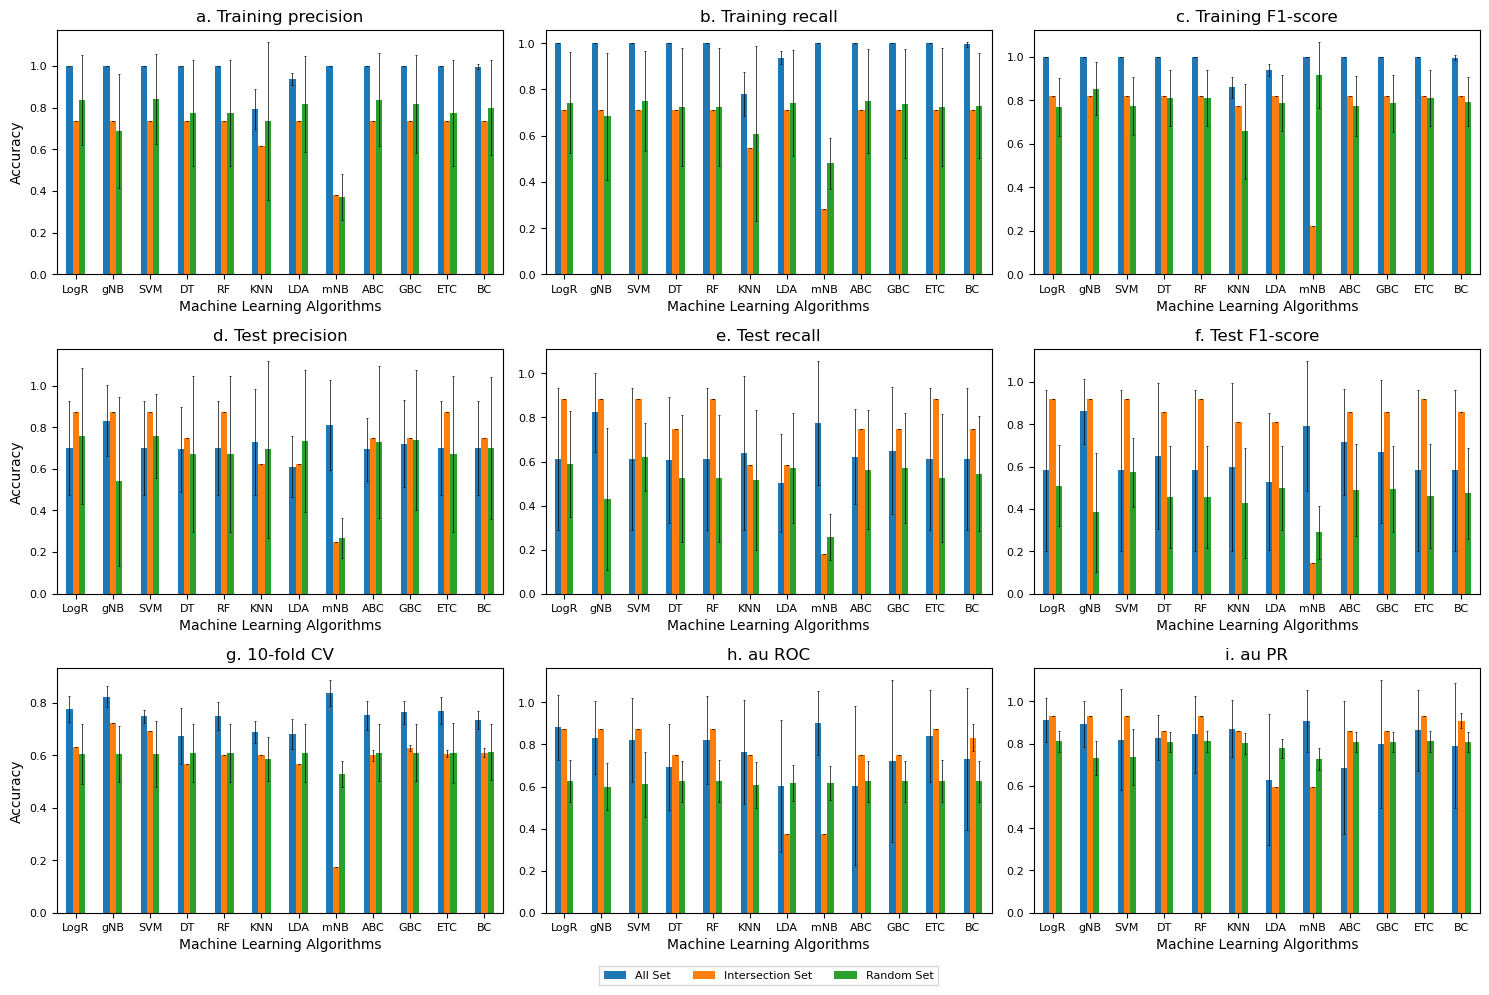

In [2]:
#Plot All set, Intersection set, Random set performance comparision figures
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from matplotlib import rc
%matplotlib inline

level='DEG_Level'

#Open files to dataframe
d1 = pd.read_csv(f'Multipartite_{level}_All_Set_Performance.csv')
d2 = pd.read_csv(f'3.Multipartite_{level}_Intersection_Set_Performance.csv' )
d3 = pd.read_csv(f'4.Multipartite_{level}_Random_Set_Performance.csv')

#Select classifier names
models = d1[['classifier']]

#extract the average from All set, Intersection set, Random set performances
def extract_average(a, b, c):
    a_s = d1[[f'{a}']]
    i_s = d2[[f'{b}']]
    r_s = d3[[f'{c}']]
    df = pd.concat([models, a_s, i_s, r_s], axis =1)
    df.set_index(['classifier'], inplace=True)
    return df

#extraact the standard deviation for y-error
def extract_stdev(a, b, c):
    a_s_std = d1[[f'{a}']]
    i_s_std = d2[[f'{b}']]
    r_s_std = d3[[f'{c}']]
    df1_std = pd.concat([models, a_s_std, i_s_std, r_s_std], axis =1)
    df1_std.set_index(['classifier'], inplace=True)
    yerr_df1 = df1_std.iloc[:, :].to_numpy().T
    return df1_std, yerr_df1

#Training precision
Training_precision = extract_average('tr_precision_avg_as','tr_precision_avg_is', 'tr_precision_avg_rs')
#Training precision yerror
Training_precision_yerror =  extract_stdev('tr_precision_stdev_as', 'tr_precision_stdev_is','tr_precision_stdev_rs')[1]
#Training recall
Training_recall = extract_average('tr_recall_avg_as','tr_recall_avg_is', 'tr_recall_avg_rs')
#Training recall yerror
Training_recall_yerror = extract_stdev('tr_precision_stdev_as', 'tr_precision_stdev_is','tr_precision_stdev_rs')[1]
#Training F1
Training_F1 = extract_average('tr_f1_avg_as','tr_f1_avg_is', 'tr_f1_avg_rs')
#Training F1 yerror
Training_F1_yerror = extract_stdev('tr_f1_stdev_as', 'tr_f1_stdev_is','tr_f1_stdev_rs')[1]
#Test precision
Test_precision = extract_average('te_precision_avg_as','te_precision_avg_is', 'te_precision_avg_rs')
#Test precision yerror
Test_precision_yerror =  extract_stdev('te_precision_stdev_as', 'te_precision_stdev_is','te_precision_stdev_rs')[1]
#Test recall
Test_recall = extract_average('te_recall_avg_as','te_recall_avg_is', 'te_recall_avg_rs')
#Test precision yerror
Test_recall_yerror =  extract_stdev('te_recall_stdev_as', 'te_recall_stdev_is','te_recall_stdev_rs')[1]
#Test F1
Test_F1 = extract_average('te_f1_avg_as','te_f1_avg_is', 'te_f1_avg_rs')
#Test precision stdev
Test_F1_stdev = extract_stdev('te_f1_stdev_as', 'te_f1_stdev_is','te_f1_stdev_rs')[0]
#Test precision yerror
Test_F1_yerror =  extract_stdev('te_f1_stdev_as', 'te_f1_stdev_is','te_f1_stdev_rs')[1]
#Ten fold CV
TenFold_CV = extract_average('Tf_CV_Avg_as','Tf_CV_Avg_is', 'Tf_CV_Avg_rs')
#Ten fold yerror
TenFold_CV_yerror =  extract_stdev('Tf_CV_stdev_as', 'Tf_CV_stdev_is','Tf_CV_stdev_rs')[1]

#Au_ROC
Au_ROC = extract_average('au_ROC_avg_as','au_ROC_avg_is', 'au_ROC_avg_rs')
#TAu_ROC yerror
Au_ROC_yerror =  extract_stdev('au_ROC_stdev_as', 'au_ROC_stdev_is','au_ROC_stdev_rs')[1]

#Au_PR
Au_PR = extract_average('au_PR_avg_as','au_PR_avg_is', 'au_PR_avg_rs')
#TAu_ROC yerror
Au_PR_yerror = extract_stdev('au_PR_stdev_as', 'au_PR_stdev_is','au_PR_stdev_rs')[1]

#plot figure
fig, axes = plt.subplots(nrows=3, ncols=3, sharex=False, sharey=False, figsize=(15,10))
ax1 = Training_precision.plot(kind='bar', ax=axes[0,0], 
                              title='a. Training precision',legend=False, rot=0, fontsize=8, 
                              xlabel='Machine Learning Algorithms', ylabel='Accuracy',
                             yerr= Training_precision_yerror, error_kw=dict(lw = 0.5, capsize = 1, capthick =0.5))

ax1 = Training_recall.plot(kind='bar', ax=axes[0,1], title='b. Training recall', legend=False, rot=0, fontsize=8, 
                           xlabel='Machine Learning Algorithms',
                          yerr= Training_recall_yerror, error_kw=dict(lw = 0.5, capsize = 1, capthick =0.5))
ax1 = Training_F1.plot(kind='bar', ax=axes[0,2], title='c. Training F1-score', legend=False, rot=0, fontsize=8, 
                       xlabel='Machine Learning Algorithms',
                      yerr= Training_F1_yerror, error_kw=dict(lw = 0.5, capsize = 1, capthick =0.5))

ax1 = Test_precision.plot(kind='bar', ax=axes[1,0], title='d. Test precision', legend=False, rot=0, fontsize=8, 
                          xlabel='Machine Learning Algorithms', ylabel='Accuracy',
                         yerr= Test_precision_yerror, error_kw=dict(lw = 0.5, capsize = 1, capthick =0.5))
ax1 = Test_recall.plot(kind='bar', ax=axes[1,1], title='e. Test recall', legend=False, rot=0, fontsize=8, 
                       xlabel='Machine Learning Algorithms',
                      yerr= Test_recall_yerror, error_kw=dict(lw = 0.5, capsize = 1, capthick =0.5))
ax1 = Test_F1.plot(kind='bar', ax=axes[1,2], title='f. Test F1-score', legend=False, rot=0, fontsize=8, 
                   xlabel='Machine Learning Algorithms',
                  yerr= Test_F1_yerror, error_kw=dict(lw = 0.5, capsize = 1, capthick =0.5))

ax1 = TenFold_CV.plot(kind='bar', ax=axes[2,0], title='g. 10-fold CV', legend=False, rot=0, fontsize=8, 
                      xlabel='Machine Learning Algorithms', ylabel='Accuracy',
                     yerr= TenFold_CV_yerror, error_kw=dict(lw = 0.5, capsize = 1, capthick =0.5))
ax8 = Au_ROC.plot(kind='bar', ax=axes[2,1], title='h. au ROC', legend=False, rot=0, fontsize=8, 
                  xlabel='Machine Learning Algorithms',
                 yerr= Au_ROC_yerror, error_kw=dict(lw = 0.5, capsize = 1, capthick =0.5))

ax8.legend(labels=['All Set', 'Intersection Set', 'Random Set'], loc='lower center', borderaxespad=0.1, ncol=3,
               bbox_to_anchor=(0.5, -0.3),
               fancybox=False, shadow=False, prop={'size': 8})
ax8.set_axisbelow(True)

ax1 = Au_PR.plot(kind='bar', ax=axes[2,2], title='i. au PR', legend=False, rot=0, fontsize=8, 
                 xlabel='Machine Learning Algorithms',
                yerr= Au_PR_yerror, error_kw=dict(lw = 0.5, capsize = 1, capthick =0.5))
fig.tight_layout()

print("Assessment of the performance of the machine learning algorithms in predicting Multipartite Vs. Unipartite, differentially present gene, genomes under 6-fold cross validation settings. The preformance metrics i) training precision, ii) training recall, iii) training F1, iv) test precision, v) test recall, vi) test F1, vii) 10f CV (ten-fold cross validation), viii) au PR (area under precision recall curve), and ix) au ROC (area under ROC curve). 'All' denotes all genes for taraining (as in the cross-validation partioning), 'Intersection' refers to genes that consistently ranked high across all 6 rounds of cross-validation, and 'Random' refers to randomly sampled genes.")

fig.savefig(f'ML_Plot_Multipartite_{level}.tiff', dpi=300, format="tiff", pil_kwargs={"compression": "tiff_lzw"});


In [3]:
#Top 15 consistent genes
Final_Consistent_Genes_Multipartite.iloc[:15]

,Feature
0,transcriptional regulator
1,chemotaxis protein
2,sugar ABC transporter permease
3,flagellar M-ring protein FliF
4,acetolactate synthase
5,PAS domain-containing protein
6,sugar ABC transporter substrate-binding protein
7,porin
8,cell envelope biogenesis protein TolA
9,hybrid sensor histidine kinase/response regulator
